## Problem Set #[2] - Integration
MACS 30150, Dr. Evans    
Linghui Wu

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.stats import norm, lognorm

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

### Exercise 2.1.

In [2]:
def integration(g, a, b, N, method):
    if method not in ["midpoint", "trapezoid", "Simpsons"]:
        raise ValueError
    else:
        if method == "midpoint":
            itgr = 0
            for i in range(N):
                xi = a + (2 * i + 1) * (b - a) / (2 * N)
                itgr += g(xi) * (b - a) / N
            return itgr
        elif method == "trapezoid":
            itgr = g(a) + g(b)
            for i in range(1, N):
                xi = a + i * (b - a) / N
                itgr += 2 * g(xi)
            return (b - a) / (2 * N) * itgr
        elif method == "Simpsons":
            itgr = g(a) + g(b)
            for i in range(1, 2 * N):
                xi = a + i * (b - a) / (2 * N)
                if i % 2 == 0:
                    itgr += 2 * g(xi)
                else:
                    itgr += 4 * g(xi)
            return (b - a) / (6 * N) * itgr

In [3]:
g = lambda x: 0.1 * x ** 4 - 1.5 * x ** 3 + 0.53 * x * x + 2 * x + 1
N = 200
mid = integration(g, -10, 10, N, "midpoint")
tra = integration(g, -10, 10, N, "trapezoid")
sim = integration(g, -10, 10, N, "Simpsons")
tru_val = 4373 + 1 / 3

methods = ["Midpoint", "Trapezoid", "Simpsons"]
approxs = [mid, tra, sim]
for m, a in zip(methods, approxs):
    print(m, "'s approximation value:\t\t", a)
    print("Difference between ", m, "and  true value: \t", abs(a - tru_val))

Midpoint 's approximation value:		 4372.991172499995
Difference between  Midpoint and  true value: 	 0.34216083333831193
Trapezoid 's approximation value:		 4374.01766
Difference between  Trapezoid and  true value: 	 0.6843266666674026
Simpsons 's approximation value:		 4373.333334999998
Difference between  Simpsons and  true value: 	 1.666665411903523e-06


### Exercise 2.1. (a)

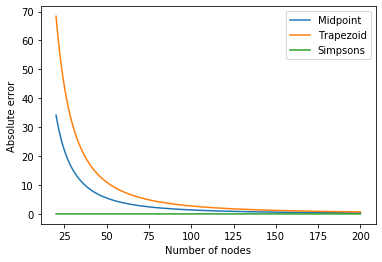

In [4]:
nvec = np.arange(20, 201, 1)

e_mid = np.zeros(0)
e_tra = np.zeros(0)
e_sim = np.zeros(0)

for i in range(20, 201):
    e_mid = np.append(e_mid, abs(integration(g, -10, 10, i, "midpoint") - tru_val))
    e_tra = np.append(e_tra, abs(integration(g, -10, 10, i, "trapezoid") - tru_val))
    e_sim = np.append(e_sim, abs(integration(g, -10, 10, i, "Simpsons") - tru_val))
    
# plot the figure
plt.plot(nvec, e_mid, label="Midpoint")
plt.plot(nvec, e_tra, label="Trapezoid")
plt.plot(nvec, e_sim, label="Simpsons")
plt.legend(loc="upper right")
plt.xlabel("Number of nodes")
plt.ylabel("Absolute error")
plt.show()

### Exercise 2.1. (b)

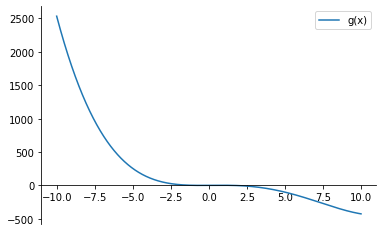

In [5]:
# plot g(x)

x_val = np.linspace(-10, 10, 10000)
ax = plt.gca()
ax.plot(x_val, g(x_val), label="g(x)")
ax.spines["bottom"].set_position("zero")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend()
plt.show()

**Considering that g(x) is a polynomial function of the 4th order and is non-liner in x, the Simpsons method offers the best accuracy because it is a non-linear approximation. Trapezoid rule has the largest estimation error since it is largely affected by the convexity and concavity of the function. From the figure above, we can see that in the range \[-10, 10\], g(x) is concave in \[-10, 2\] and convex in \[2, 10\]. As a result, the trapezoid rule in the larger concave part lead to a overestimate result. Midpoint rule employs rectangles to approximate and is less influenced by the concavity and convexity in contrast with the trapezoid rule.**

**As a result, for g(x), the rank of the three estimation methods, from best to worst, is the Simpsons, the Midpoint and the Trapezoid.**

### Exercise 2.2.

In [6]:
def NC_discrete(mean, sigma, N, k):
    z = np.linspace(mean - k * sigma, mean + k * sigma, N)
    w = np.zeros(N)
    w[0] = norm.cdf((z[0] + z[1]) / 2, loc=mean, scale=sigma) 
    w[-1] = 1 - norm.cdf((z[-1] + z[-2]) / 2, loc=mean, scale=sigma)
    for i in range(1, N-1):
        z_min = (z[i-1] + z[i]) / 2
        z_max = (z[i] + z[i+1]) / 2
        norm_pdf = lambda x: norm.pdf(x, loc=mean, scale=sigma)
        w[i] = quad(norm_pdf, z_min, z_max)[0]
    return z, w

In [8]:
z

array([0.5, 1.4, 2.3, 3.2, 4.1, 5. , 5.9, 6.8, 7.7, 8.6, 9.5])

In [9]:
w

array([0.00346697, 0.01439745, 0.04894278, 0.11725292, 0.19802845,
       0.23582284, 0.19802845, 0.11725292, 0.04894278, 0.01439745,
       0.00346697])

In [7]:
z, w = NC_discrete(5, 1.5, 11, 3)
norm_df = pd.DataFrame({"z":z, "weight": w})
norm_df.index += 1
norm_df

,z,weight
1,0.5,0.003467
2,1.4,0.014397
3,2.3,0.048943
4,3.2,0.117253
5,4.1,0.198028
6,5.0,0.235823
7,5.9,0.198028
8,6.8,0.117253
9,7.7,0.048943
10,8.6,0.014397


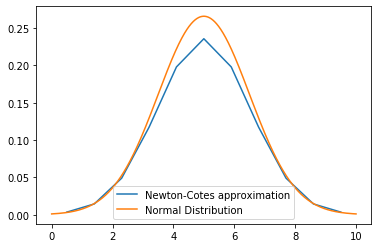

In [18]:
plt.plot(z, w, label="Newton-Cotes approximation")

x = np.linspace(0, 10, 1000)
plt.plot(x, norm.pdf(x, 5, 1.5), label="Normal Distribution")

plt.legend(loc="best")
plt.show()

**It can be inferred from the graph that the Newton-Cotes discrete method is a good approximation of the normal distribution.**

### Exercise 2.3.

In [9]:
def NC_logdiscrete(mean, sigma, N, k):
    z, w = NC_discrete(mean, sigma, N, k)
    A = np.exp(z)
    return A, w

In [10]:
A, w = NC_logdiscrete(5, 1.5, 11, 3)
lognorm_df = pd.DataFrame({"A": A, "weight": w})
lognorm_df.index += 1
lognorm_df

,A,weight
1,1.648721,0.003467
2,4.055200,0.014397
3,9.974182,0.048943
4,24.532530,0.117253
5,60.340288,0.198028
6,148.413159,0.235823
7,365.037468,0.198028
8,897.847292,0.117253
9,2208.347992,0.048943
10,5431.659591,0.014397


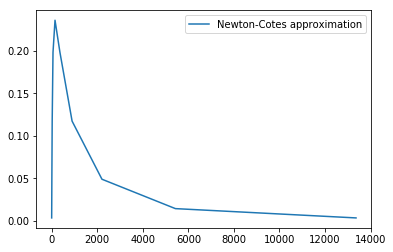

In [11]:
plt.plot(A, w, label="Newton-Cotes approximation")
plt.legend(loc="upper right")
plt.show()

### Exercise 2.4.

In [12]:
mean = 10.5
sigma = 0.8

w, z = NC_logdiscrete(mean, sigma, 11, 3)
approx_income = sum(w * z)
exact_income = np.exp(mean + sigma ** 2 / 2)
print("My approximation: ", approx_income)
print("The exact expected value: ", exact_income)
print("The difference: ", abs(approx_income - exact_income))

My approximation:  50352.456192765894
The exact expected value:  50011.087008521754
The difference:  341.36918424414034


### Exercise 3.1.

In [13]:
from scipy import optimize

def Gaus(g, a, b, N):
    init_weight = [1 / N for i in range(N)]
    init_x = [a + i * (b - a) / (N - 1) for i in range(N)]
    init = init_weight + init_x

    def funcs(x):
        result = []
        for i in range(2 * N):
            weight = x[:N]
            node = x[N:]
            equal_right = sum(weight[k] * (node[k] ** i) for k in range(N))
            equal_left = (b ** (i + 1) - a ** (i + 1)) / (i + 1)
            result.append(equal_left - equal_right)
        return tuple(val for val in result)

    optimal = [val for val in optimize.root(funcs, init)["x"]]
    weights = optimal[:N]
    nodes = optimal[N:]
    rv = 0
    for i in range(N):
        rv += weights[i] * g(nodes[i])
    return rv, weights, nodes

In [14]:
g = lambda x: 0.1 * x ** 4 - 1.5 * x ** 3 + 0.53 * x * x + 2 * x + 1
gaus1, weights, nodes = Gaus(g, -10, 10, 3)

print("The Gaussian quadrature nodes:", nodes)
print("The Gaussian quadrature weights:", weights)
print("Gaussian Quadrature method approximation value:", gaus1)
print("Difference between Gaussian Quadrature method and the true value:", abs(gaus1 - tru_val))

The Gaussian quadrature nodes: [-7.745966692834513, 6.129873603502169e-10, 7.745966692737809]
The Gaussian quadrature weights: [5.555555554280963, 8.88888889109055, 5.555555554628487]
Gaussian Quadrature method approximation value: 4373.333333189601
Difference between Gaussian Quadrature method and the true value: 1.4373199519468471e-07


**The Gaussian method provides a approximate integral to the 7th decimal of the true value.**

**Note that the weights and nodes calculated by the `scipy.optimize.root` method have some fractional error compared to a more accurate N=3 weights and nodes(https://pomax.github.io/bezierinfo/legendre-gauss.html#n3).**

In [15]:
import math
a, b = -10, 10
(w1, w2, w3, x1, x2, x3) = (8/9, 5/9, 5/9, 0, -math.sqrt(0.6), math.sqrt(0.6))
s, e = (b - a) / 2, (b + a) / 2
gaus2 = s * (w1 * g(s * x1 + e) + w2 * g(s * x2 + e) + w3 * g(s * x3 + e))

print("More accurate Gaussian Quadrature method approximation value:", gaus2)
print("Difference between Gaussian Quadrature method and the true value:", abs(gaus2 - tru_val))

More accurate Gaussian Quadrature method approximation value: 4373.333333333334
Difference between Gaussian Quadrature method and the true value: 9.094947017729282e-13


**Compared to the approximations from Exercise 2.1., the accuracy improves using the Gaussian quadrature method.**

### Exercise 3.2.

In [16]:
from scipy.integrate import quad
g = lambda x: 0.1*x** 4 - 1.5*x**3 + 0.53*x*x + 2*x + 1
gaus3 = quad(g, -10, 10)[0]

print("Scipy Gaussian Quadrature method approximation value:", gaus3)
print("Difference between Gaussian Quadrature method and the true value:", abs(gaus3 - tru_val))

Scipy Gaussian Quadrature method approximation value: 4373.333333333334
Difference between Gaussian Quadrature method and the true value: 9.094947017729282e-13


**The approximation error is so far the smallest using the Python Gaussian quadrature command.**

### Exercise 4.1.

In [19]:
np.random.seed(seed = 25)
g = lambda x, y: x**2 + y**2 <= 1

def MonteCarlo(g, omega, N):
    rand_x = np.random.uniform(omega[0][0], omega[0][1], N)
    rand_y = np.random.uniform(omega[1][0], omega[1][1], N)
    total = np.sum(g(rand_x, rand_y))
    
    area = abs(omega[0][0]- omega[0][1]) * abs(omega[1][0]- omega[1][1])
    return area * total / N

In [20]:
N = 1
omega = np.array([[-1, 1], [-1, 1]])
while round(MonteCarlo(g, omega, N), 4) != 3.1415:
    N += 1
print("The smallest number of random draws N is ", N)

The smallest number of random draws N is  615


### Exercise 4.2.

In [19]:
import numpy as np

def isPrime(n):
    '''
    --------------------------------------------------------------------
    This function returns a boolean indicating whether an integer n is a
    prime number
    --------------------------------------------------------------------
    INPUTS:
    n = scalar, any scalar value

    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None

    OBJECTS CREATED WITHIN FUNCTION:
    i = integer in [2, sqrt(n)]

    FILES CREATED BY THIS FUNCTION: None

    RETURN: boolean
    --------------------------------------------------------------------
    '''
    for i in range(2, int(np.sqrt(n) + 1)):
        if n % i == 0:
            return False

    return True

In [20]:
def primes_ascend(N, min_val=2):
    '''
    --------------------------------------------------------------------
    This function generates an ordered sequence of N consecutive prime
    numbers, the smallest of which is greater than or equal to 1 using
    the Sieve of Eratosthenes algorithm.
    (https://en.wikipedia.org/wiki/Sieve_of_Eratosthenes)
    --------------------------------------------------------------------
    INPUTS:
    N       = integer, number of elements in sequence of consecutive
              prime numbers
    min_val = scalar >= 2, the smallest prime number in the consecutive
              sequence must be greater-than-or-equal-to this value

    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        isPrime()

    OBJECTS CREATED WITHIN FUNCTION:
    primes_vec     = (N,) vector, consecutive prime numbers greater than
                     min_val
    MinIsEven      = boolean, =True if min_val is even, =False otherwise
    MinIsGrtrThn2  = boolean, =True if min_val is
                     greater-than-or-equal-to 2, =False otherwise
    curr_prime_ind = integer >= 0, running count of prime numbers found

    FILES CREATED BY THIS FUNCTION: None

    RETURN: primes_vec
    --------------------------------------------------------------------
    '''
    primes_vec = np.zeros(N, dtype=int)
    MinIsEven = 1 - min_val % 2
    MinIsGrtrThn2 = min_val > 2
    curr_prime_ind = 0
    if not MinIsGrtrThn2:
        i = 2
        curr_prime_ind += 1
        primes_vec[0] = i
    i = min(3, min_val + (MinIsEven * 1))
    while curr_prime_ind < N:
        if isPrime(i):
            curr_prime_ind += 1
            primes_vec[curr_prime_ind - 1] = i
        i += 2

    return primes_vec

In [23]:
np.arange(3.0, 7.5, 0.25)

array([3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25, 5.5 ,
       5.75, 6.  , 6.25, 6.5 , 6.75, 7.  , 7.25])

In [21]:
def equiseq(n, d, seq):
    prime_seq = primes_ascend(d, min_val = 2)
    if seq == "Weyl":
        weyl_1 = np.sqrt(prime_seq) * n
        weyl = weyl_1 - np.floor(weyl_1)
        return weyl
    elif seq == "Haber":
        haber_1 = np.sqrt(prime_seq) * n * (n+1) / 2
        haber = haber_1 - np.floor(haber_1)
        return haber
    elif seq == "Niederreiter":
        e = np.arange(1, d + 1) / (d + 1)
        niederreiter_1 = n * (2 ** e)
        niederreiter = niederreiter_1 - np.floor(niederreiter_1)
        return niederreiter    
    elif seq == "Baker":
        baker_1 = n * np.exp(prime_seq)
        baker = baker_1 - np.floor(baker_1)
        return baker

In [22]:
for i in ["Weyl", "Haber", "Niederreiter", "Baker"]:
    print(i, ": ", equiseq(20, 4, i))

Weyl :  [0.28427125 0.64101615 0.72135955 0.91502622]
Haber :  [0.9848481  0.73066959 0.57427527 0.60777532]
Niederreiter :  [0.9739671  0.39015822 0.31433133 0.82202253]
Baker :  [0.78112198 0.71073846 0.26318205 0.66316857]


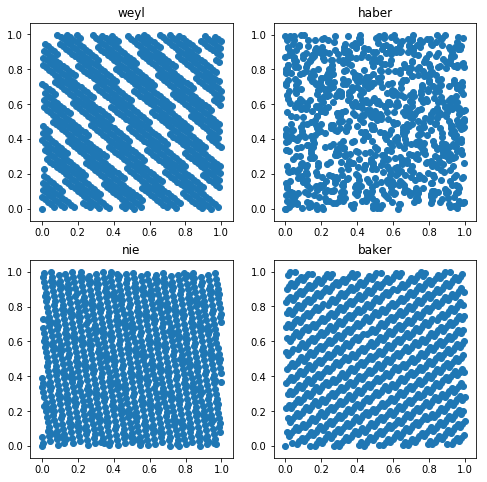

In [23]:
# plot for testing

x_1, y_1 = [], []
x_2, y_2 = [], []
x_3, y_3 = [], []
x_4, y_4 = [], []


for i in range(0, 1000):
    x_1.append(equiseq(i, 2,'Weyl')[0])
    y_1.append(equiseq(i, 2,'Weyl')[1])
    x_2.append(equiseq(i, 2,'Haber')[0])
    y_2.append(equiseq(i, 2,'Haber')[1])
    x_3.append(equiseq(i, 2,'Niederreiter')[0])
    y_3.append(equiseq(i, 2,'Niederreiter')[1])    
    x_4.append(equiseq(i, 2,'Baker')[0])
    y_4.append(equiseq(i, 2,'Baker')[1])

fig = plt.figure(figsize=(8, 8))

ax1 = fig.add_subplot(221)
ax1.scatter(x_1, y_1)
ax1.set_title("weyl")

ax2 = fig.add_subplot(222)
ax2.scatter(x_2, y_2)
ax2.set_title("haber")

ax3 = fig.add_subplot(223)
ax3.scatter(x_3, y_3)
ax3.set_title("nie")

ax4 = fig.add_subplot(224)
ax4.scatter(x_4, y_4)
ax4.set_title("baker")
plt.show()

### Exercise 4.3.

In [24]:
np.random.seed(seed=25)
g = lambda x, y: x**2 + y**2 <= 1

def QuasiMonteCarlo(g, omega, N, seq):
    var = []
    for i in range(N):
        var.append((2 * equiseq(i, 2, seq)[0] - 1, 2 * equiseq(i, 2, seq)[1] - 1))
    total = 0
    for i in range(N):
        total += g(var[i][0], var[i][1])
    area = abs(omega[0][0]- omega[0][1]) * abs(omega[1][0]- omega[1][1])
    return area * total / N

In [25]:
print("The approximation of pi")
omega = np.array([[-1, 1,], [-1, 1]])
N = 100
for i in ["Weyl", "Haber", "Niederreiter", "Baker"]:
    print(i, ": ", QuasiMonteCarlo(g, omega, N, i), sep="")

The approximation of pi
Weyl: 3.08
Haber: 3.36
Niederreiter: 3.12
Baker: 3.2


In [26]:
def min_N(seq):
    N = 1
    while round(QuasiMonteCarlo(g, omega, N, seq), 4) != 3.1415:
        N += 1
        if N >= 5000:
            print(i, "'s smallest number of random draws exceeds 5000'", sep="")
            break
    print("The smallest number of random draws N with ", i, " is ", N, sep="")

In [27]:
for i in ["Weyl", "Haber", "Niederreiter", "Baker"]:
    min_N(i)

The smallest number of random draws N with Weyl is 1230
The smallest number of random draws N with Haber is 2064
The smallest number of random draws N with Niederreiter is 1845
The smallest number of random draws N with Baker is 1272


**The results above show that `Weyl` is the fastest method converging to 3.1415, followed by `Baker` and `Niederreiter`, `Haber` is the slowest one.**